# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

In [32]:
def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        if ptpD:
            mses_per_dataset = model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=True)
            mses_per_dataset = sum(mses_per_dataset[:18]) + sum(mses_per_dataset[19:])
            mses.append(mses_per_dataset)
        else:
            mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=False)[:18]))
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = EA_theta_set[re_idx]
    mses = np.sort(mses)
    return mses, thetas

def sort_mses_thetas(mses, thetas):
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = thetas[re_idx]
    return np.sort(mses), thetas

def calc_mse(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False):
    if ptpD:
        mses_per_dataset = model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=True)
        mses = sum(mses_per_dataset[:18]) + sum(mses_per_dataset[19:])
    else:
        mses = sum(model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False)[:18])
    return mses

def def_schedules(sorted_mses):
    best_mse = sorted_mses[0]
    worst_mse = sorted_mses[-1]
    
#     e1 = (best_mse+worst_mse)/2 #will take longer to run
    e1 = worst_mse
    e2 = (e1+best_mse)/2
    e3 = (e2+best_mse)/2
    e4 = (e3+best_mse)/2
#     e5 = (e4+best_mse)/2
    return e1, e2, e3, e4
    
def scaled_prob_mses(mses, top=.99, bot=.01):
    # mses is SORTED 
    scale = [(top-bot)*(x-mses[0])/(mses[-1]-mses[0])+bot for x in mses]
    inv = [1/x for x in scale]
    probs = [x/sum(inv) for x in inv]
    return probs

def draw_thetas(sorted_params, probs):
    idx = np.random.choice(range(len(sorted_params)), 1, p=probs)
    return sorted_params[idx][0]

def step_theta(theta):
    log_theta = np.log10(theta) 
    theta_prime = np.concatenate([10**(np.random.uniform(x-.1,x+.1,1)) for x in log_theta], axis=0)
    return theta_prime

def run_schedule(prior_thetas, probs, ei, num_theta_primes):
    thetas_ei = []
    mses_ei = []
    c = collections.Counter({'Pass': 0, 'Fail': 0}) 
    while len(thetas_ei) < num_theta_primes:
        theta = draw_thetas(prior_thetas, probs)
        theta_prime = step_theta(theta)
        mse = calc_mse(M3c_fxns, theta_prime, exp_data, exp_time, params_constants, initials, ptpD=True) ##AMY error fxn
        if mse < ei:
            c['Pass'] += 1
            thetas_ei.append(theta_prime)
            mses_ei.append(mse)
            if len(mses_ei) % int(num_theta_primes*.1) == 0:
                print(str(int(len(mses_ei)/num_theta_primes*100)) + "% complete.") 
        else:
            c['Fail'] += 1
    return np.asarray(mses_ei), np.asarray(thetas_ei), c

# Model

## Model Variables (Constants)

In [5]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on



labelnames = ['$- fb$', '$- Hog1$','$- PTP$','$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$','$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_{M9}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{M10}$']

minimums = [-4, -4, -4, -4, 
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4]

maximums = [ 4,  4, 8, 4, 
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly,  PTP]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1,  PTP] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

# Load experimental data

In [6]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_long = [mapk_t100a_data[0]] 

mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:] #shorten for plotting



# Load simulation data

In [9]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191106_kb_M3c_long/'
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191115_kb_M4/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)

M3c_fxns = model.Model(model.M3c, model.simulate_t100a_experiment_M3c, model.M3c_nopos)
# M4_fxns = model.Model(model.M4_new, model.simulate_t100a_experiment_M4, model.simulate_nopos_experiment_M4)

Number of runs collected: 1779
Best last gen MSE: 3451.549590188612
Mean last gen MSEs of top 5%: 4245.973431779273


In [10]:
## sort
M3c_sorted_mses_EA, M3c_sorted_thetas_EA = sort_mses_thetas(last_mses, last_params)

# Check EA results

No handles with labels found to put in legend.


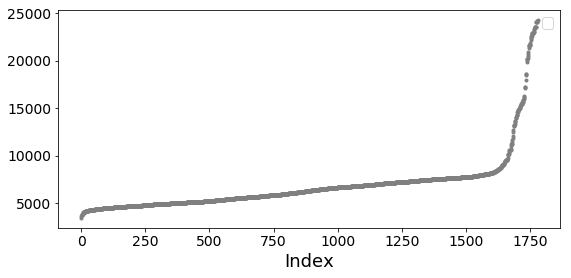

In [11]:
plotting.plt_idx_vs_mse(M3c_sorted_mses_EA, len(M3c_sorted_mses_EA))

No handles with labels found to put in legend.


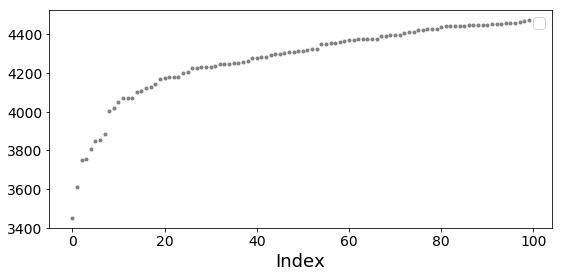

In [12]:
plotting.plt_idx_vs_mse(M3c_sorted_mses_EA, 100)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

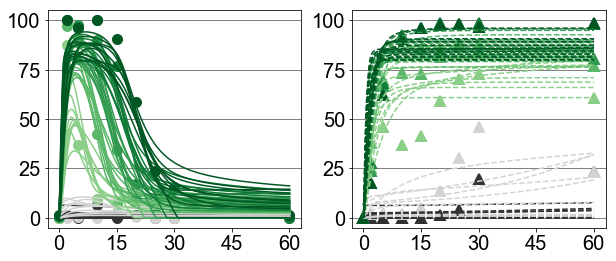

In [14]:
# original parameter values
plotting.plt_param_behaviors(M3c_fxns, M3c_sorted_thetas_EA, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

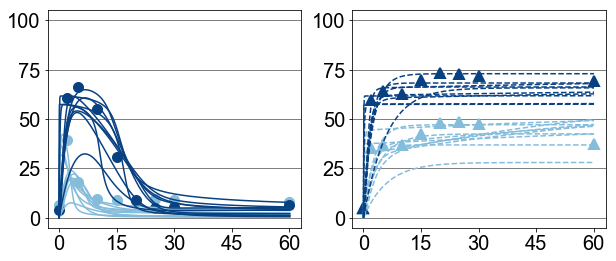

In [15]:
plotting.plt_param_behaviors(M3c_fxns, M3c_sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

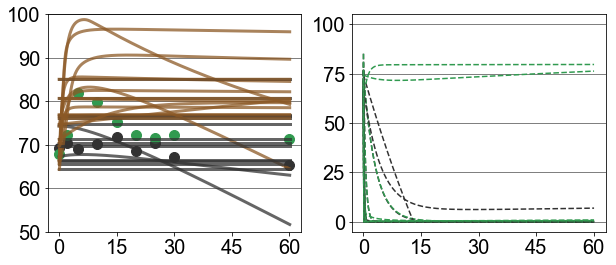

In [18]:
plotting.plt_param_behaviors(M3c_fxns, M3c_sorted_thetas_EA, 15, params_constants, initials, [0,350000], time, 2, mapk_ptpD_data, None, mapk_time, ptp23D=True, save_fig='') # [0]+map2k_doses

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

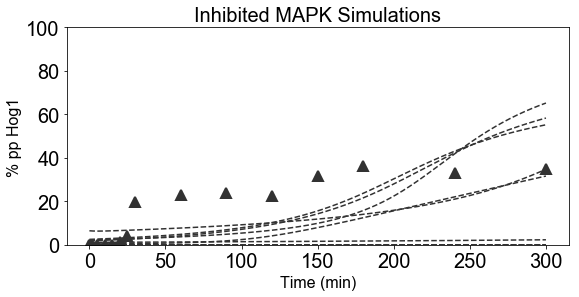

In [19]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M3c_fxns, M3c_sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


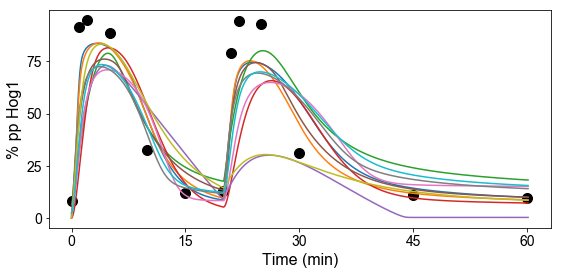

In [20]:
plotting.plt_ramp_behaviors(M3c_fxns, M3c_sorted_thetas_EA, 10, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

In [1]:
df_top_thetas_EA = pd.DataFrame(M3c_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(M3c_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

NameError: name 'pd' is not defined

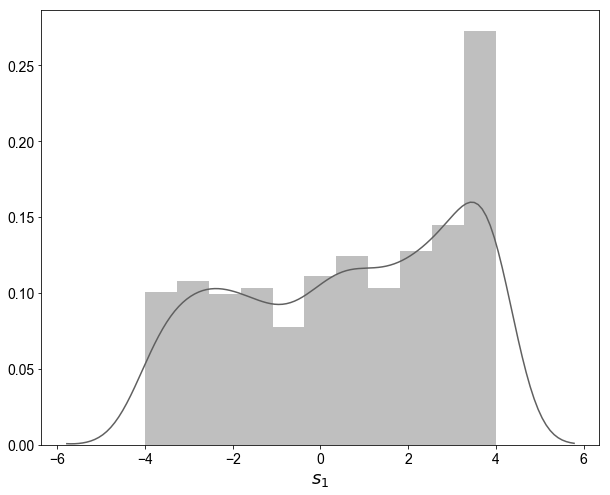

In [18]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[7]]))

In [19]:
sims_M4_kb_ea_l = plotting.simdata_to_list(M4_fxns, M4_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


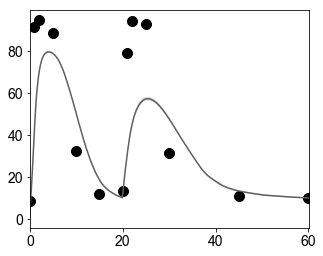

In [46]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


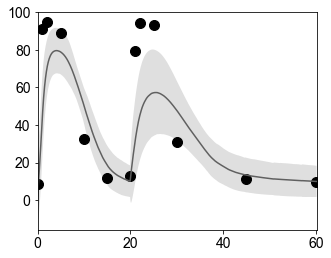

In [47]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [22]:
M3c_new_mses_EA, M3c_new_thetas_EA = recalc_mses(M3c_fxns, M3c_sorted_thetas_EA, exp_data, exp_time, params_constants, initials, ptpD=True)

print(M3c_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

[3291.62963748 3415.15773202 3487.84490605 3714.8195112  3757.87712342
 3788.40181439 3806.13330861 3812.58018675 3828.78868932 3864.42593227]


No handles with labels found to put in legend.


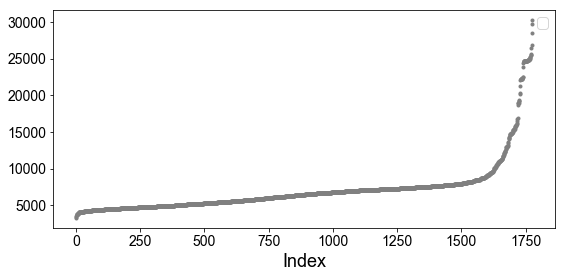

In [24]:
plotting.plt_idx_vs_mse(M3c_new_mses_EA, len(M3c_new_mses_EA)-1)

In [25]:
M3c_EA_thetas_1perc = M3c_new_thetas_EA[:500]
M3c_EA_mses_1perc = M3c_new_mses_EA[:500]

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [26]:
e1, e2, e3, e4 = def_schedules(M3c_EA_mses_1perc)

print("Best MSE: " + str(M3c_EA_mses_1perc[0]))
print("Worst MSE: " + str(M3c_EA_mses_1perc[-1]))
print()
print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
print()


Best MSE: 3291.6296374765316
Worst MSE: 5266.192918298794

Schedules: 5266.192918298794 4278.911277887662 3785.270457682097 3538.4500475793143



## Define probability

I've also been messing around with the `top` and `bot` params of `scaled_prob_mses`. 
- (.9 and .1) 
- (.95 and .05) 
- (.99 and .01)

I've noticed that with the larger number of EA thetas, the more extreme ranges are better. 
If you start with a small number of EA thetas, being more conservative with the ranges
results in more balanced probabilities.

In [30]:
probs = scaled_prob_mses(M3c_EA_mses_1perc, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])


[0.11532508695019306, 0.016172696210814047, 0.010739499045814104, 0.0052412315301633, 0.00477725799294054]
[0.0011717344006446895, 0.001170843873896791, 0.0011705974382186114, 0.0011674442124825742, 0.0011648998681837684]


## Schedule 1

I use `num_theta_primes = 1000`, but set to 100 to be faster.

In [33]:
mses_e1, thetas_e1, count_e1 = run_schedule(M3c_EA_thetas_1perc, probs, e1, num_theta_primes=1000)
mses_e1_sort, thetas_e1_sort = sort_mses_thetas(mses_e1, thetas_e1)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
../../python_modules\model.py:672: RuntimeWarning: divide by zero encountered in double_scalars
  dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:672: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:673: RuntimeWarning: invalid value encountered in double_scalars
  dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (

10% complete.


../../python_modules\model_supp.py:151: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()


20% complete.


../../python_modules\model_supp.py:162: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
../../python_modules\model_supp.py:205: RuntimeWarning: overflow encountered in square
  mses[18] = ((data - mapk[closest_idxs_ramp_time])**2).mean()


30% complete.
40% complete.
50% complete.
60% complete.


../../python_modules\model_supp.py:187: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()


70% complete.
80% complete.
90% complete.
100% complete.


In [34]:
df_top_thetas_e1 = pd.DataFrame(thetas_e1_sort)
df_top_thetas_e1.columns = labelnames

df_top_thetas_e1.to_csv('M3c_kb_thetas_e1.csv')

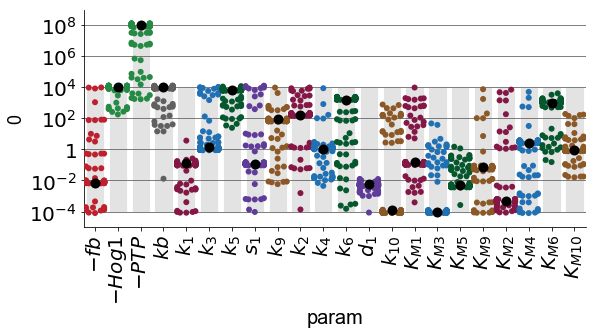

In [67]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e1_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

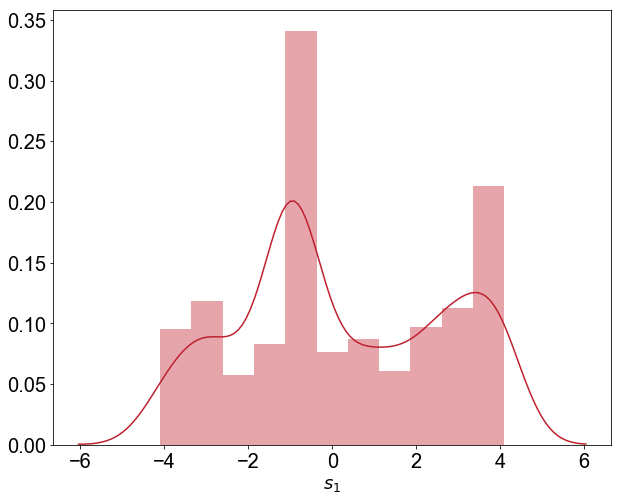

In [68]:
sns.distplot(np.log10(df_top_thetas_e1[labelnames[7]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

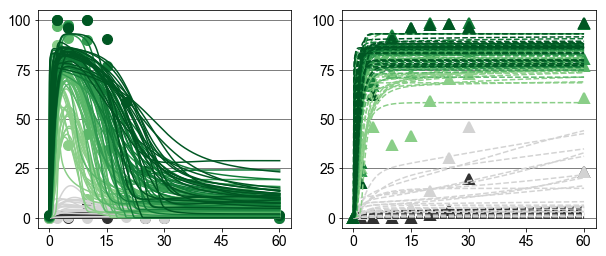

In [36]:
plotting.plt_param_behaviors(M3c_fxns, thetas_e1, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

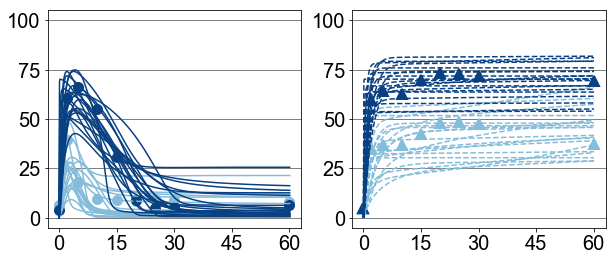

In [37]:
plotting.plt_param_behaviors(M3c_fxns, thetas_e1, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [ ]:
sims_M2b_kb_e1 = plotting.simdata_to_list(M2b_fxns, thetas_e1_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


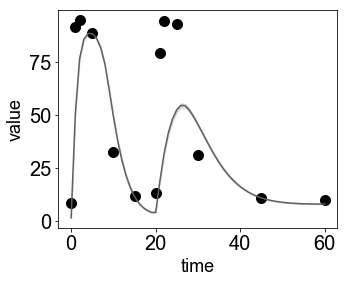

In [83]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

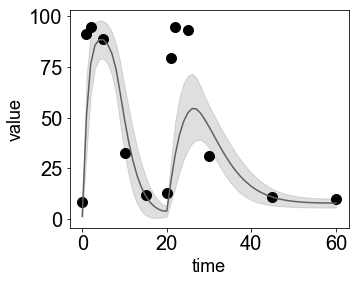

In [81]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 2

Redefine probs based on results of last schedule.

In [38]:
probs = scaled_prob_mses(mses_e1_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.0670671998178501, 0.011867173459400205, 0.0060250227867873676, 0.005524283148332002, 0.00493588227806407]
[0.0006781199749359845, 0.0006779319023879655, 0.0006778148528558584, 0.0006776318937103215, 0.0006774464628065668]


In [39]:
mses_e2, thetas_e2, count_e2 = run_schedule(thetas_e1_sort, probs, e2, num_theta_primes=1000)
mses_e2_sort, thetas_e2_sort = sort_mses_thetas(mses_e2, thetas_e2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
../../python_modules\model.py:674: RuntimeWarning: overflow encountered in double_scalars
  dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - ((k6 + alpha_2*PTP)*MAPK)/(K_6+MAPK)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning:

10% complete.


../../python_modules\model_supp.py:205: RuntimeWarning: overflow encountered in square
  mses[18] = ((data - mapk[closest_idxs_ramp_time])**2).mean()
../../python_modules\model_supp.py:182: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_t100a_long])**2).mean()
../../python_modules\model_supp.py:187: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.


../../python_modules\model_supp.py:163: RuntimeWarning: overflow encountered in double_scalars
  mse_total += mses[i]


90% complete.
100% complete.


In [40]:
df_top_thetas_e2 = pd.DataFrame(thetas_e2_sort)
df_top_thetas_e2.columns = labelnames

df_top_thetas_e2.to_csv('M3c_kb_thetas_e2.csv')

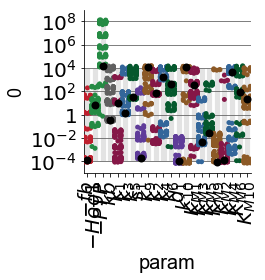

In [41]:
num_plt = 200
df_plt = pd.DataFrame(thetas_e2_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

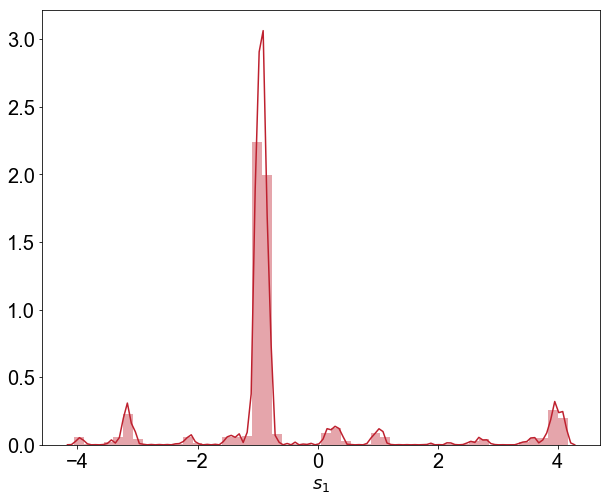

In [80]:
sns.distplot(np.log10(df_top_thetas_e2[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

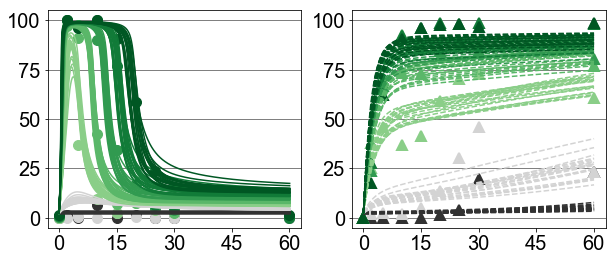

In [82]:
plotting.plt_param_behaviors(M4_fxns, thetas_e2_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

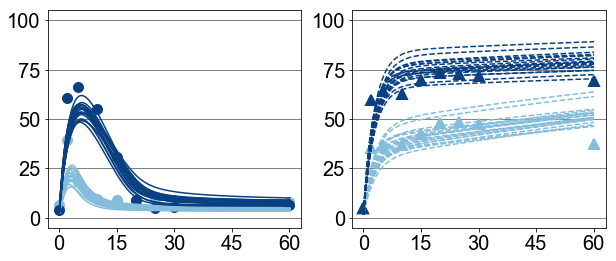

In [83]:
plotting.plt_param_behaviors(M4_fxns, thetas_e2_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [42]:
sims_M3c_kb_e2 = plotting.simdata_to_list(M3c_fxns, thetas_e2_sort, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


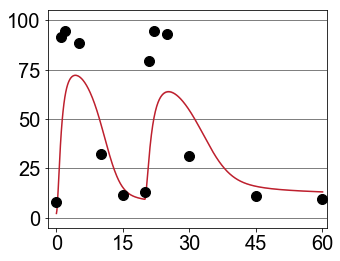

In [43]:
plotting.plt_ramp_cis(sims_M3c_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

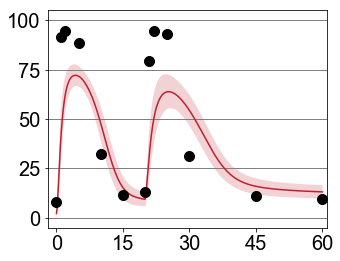

In [46]:
plotting.plt_ramp_cis(sims_M3c_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='M3c_ramp.pdf')

## Turning on and off inhib

In [103]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e2_sort, params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


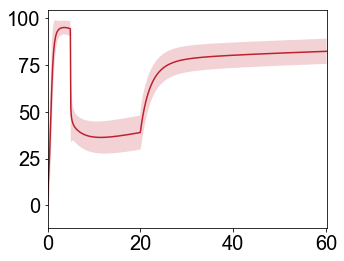

In [104]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


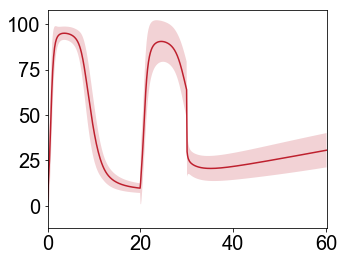

In [102]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>30 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


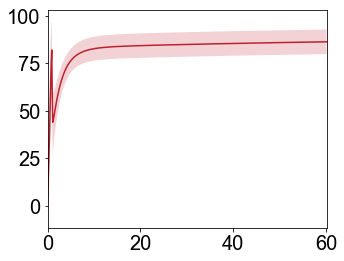

In [100]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>1

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


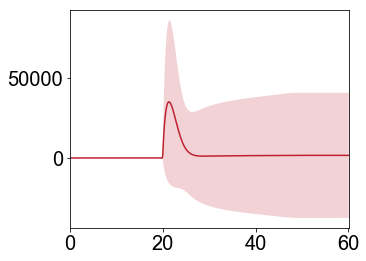

In [98]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t<20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


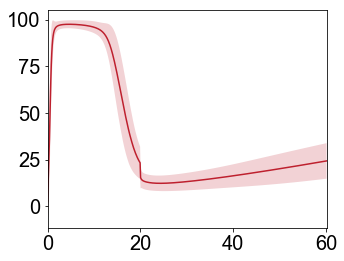

In [96]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


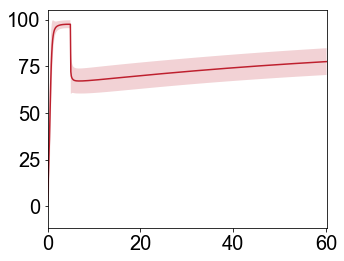

In [94]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5

### Investigating modality

PCA to see if modality can be explained by theta variance. Also, see if better scores are clustering together.

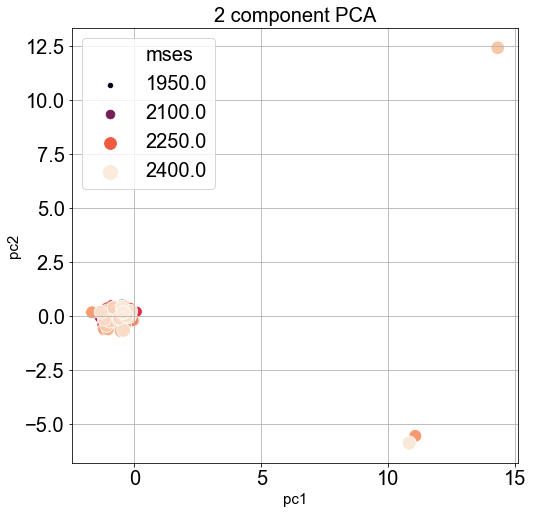

In [310]:
from sklearn.preprocessing import StandardScaler

df_top_thetas_e2_log = df_top_thetas_e2.apply(np.log10)

df_top_thetas_e2_log['mses'] = mses_e2_sort

x = df_top_thetas_e2_log.loc[:, labelnames].values
y = df_top_thetas_e2_log.loc[:,['mses']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df_top_thetas_e2_log[['mses']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sns.scatterplot(x='pc1', y='pc2', hue='mses', size='mses',sizes=(20, 200), data=finalDf[finalDf['mses']<2400], palette="rocket")

ax.grid()

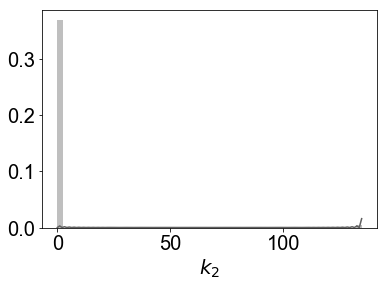

In [311]:
df_top_params_e2 = pd.DataFrame(thetas_e2)
df_top_params_e2.columns = labelnames
sns.distplot(df_top_params_e2[labelnames[7]])

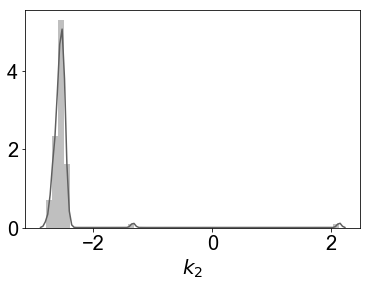

In [312]:
sns.distplot(np.log10(df_top_params_e2[labelnames[7]]))

<Figure size 432x288 with 0 Axes>

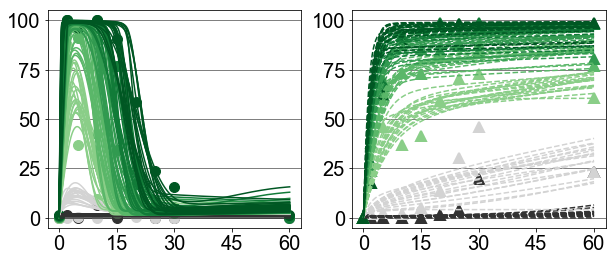

In [314]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 432x288 with 0 Axes>

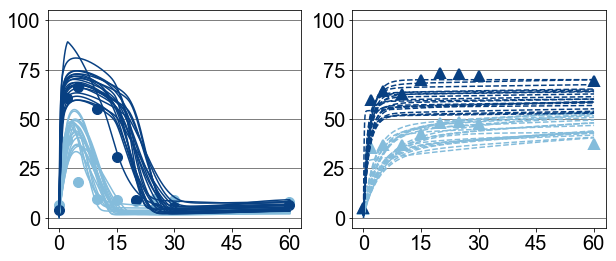

In [315]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 3 

In [47]:
probs = scaled_prob_mses(mses_e2_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.0759682921049402, 0.004280280575654486, 0.003749047272530163, 0.003185877371034525, 0.0028367674349008285]
[0.0007676823481112943, 0.0007676665772796342, 0.0007675679582214072, 0.0007675378090338123, 0.0007673564859084868]


In [49]:
mses_e3, thetas_e3, count_e3 = run_schedule(thetas_e2_sort, probs, e3, num_theta_primes=1000)
mses_e3_sort, thetas_e3_sort = sort_mses_thetas(mses_e3, thetas_e3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
../../python_modules\model.py:705: RuntimeWarning: overflow encountered in double_scalars
  dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - ((k6 + alpha_2*PTP)*MAPK)/(K_6+MAPK)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning:

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100% complete.


In [50]:
df_top_thetas_e3 = pd.DataFrame(thetas_e3_sort)
df_top_thetas_e3.columns = labelnames

df_top_thetas_e3.to_csv('M3c_kb_thetas_e3.csv')

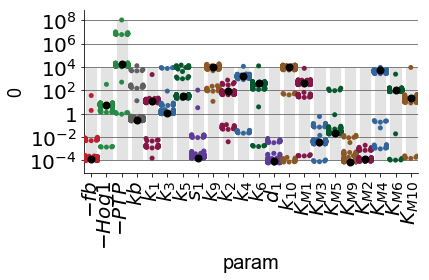

In [51]:
num_plt = 250
df_plt = pd.DataFrame(thetas_e3_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

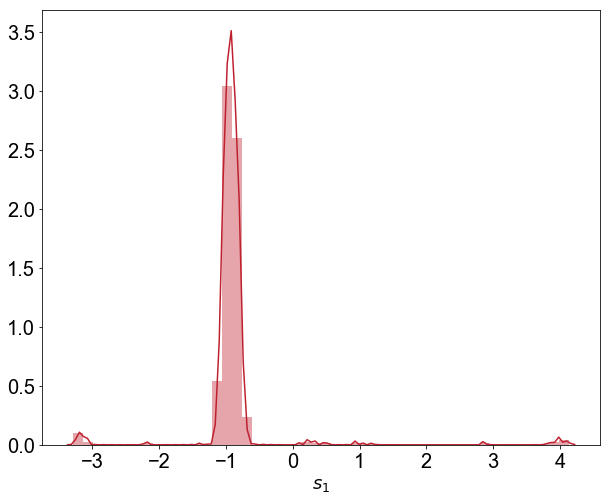

In [109]:
sns.distplot(np.log10(df_top_thetas_e3[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

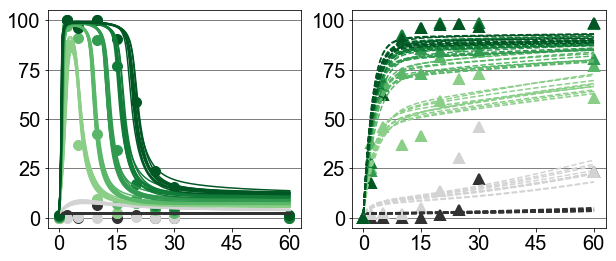

In [110]:
plotting.plt_param_behaviors(M4_fxns, thetas_e3_sort, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

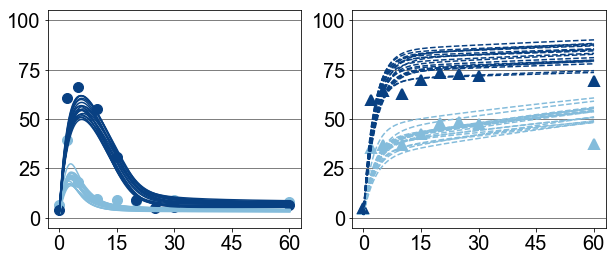

In [111]:
plotting.plt_param_behaviors(M4_fxns, thetas_e3_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [112]:
sims_M2b_kb_e3 = plotting.simdata_to_list(M4_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


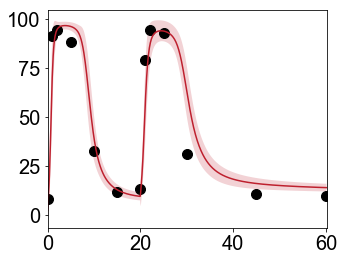

In [115]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='')

## Schedule 4

In [141]:
probs = scaled_prob_mses(mses_e3_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.051581139193633295, 0.02624409336037292, 0.01055223063730911, 0.01026465728020007, 0.009431264438801192]
[0.0005213056855445805, 0.000521193680478518, 0.0005211457078339943, 0.0005210594173096417, 0.0005210216080164979]


In [142]:
mses_e4, thetas_e4, count_e4_M2b_kb = run_schedule(thetas_e3_sort, probs, e4, num_theta_primes=1000)
mses_e4_sort, thetas_e4_sort = sort_mses_thetas(mses_e4, thetas_e4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [143]:
df_top_thetas_e4 = pd.DataFrame(thetas_e4_sort)
df_top_thetas_e4.columns = labelnames
df_top_thetas_e4.to_csv('M4_kb_thetas_e4.csv')

In [ ]:
num_plt = 250
df_plt = pd.DataFrame(df_top_thetas_e4[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

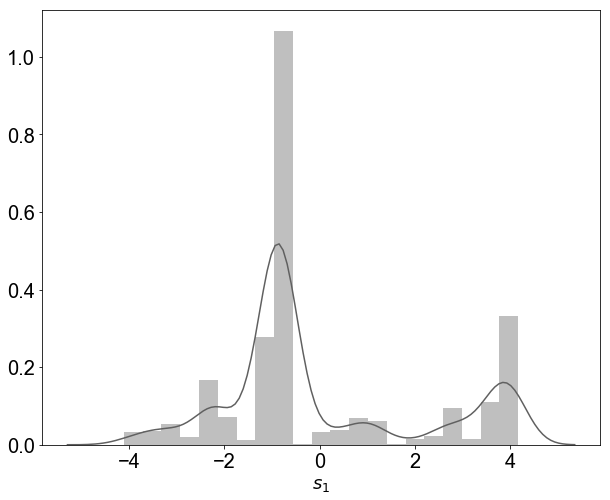

In [51]:
sns.distplot(np.log10(df_top_thetas_e4[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

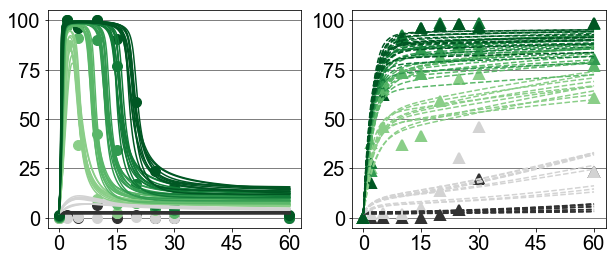

In [54]:
plotting.plt_param_behaviors(M4_fxns, thetas_e4_sort, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

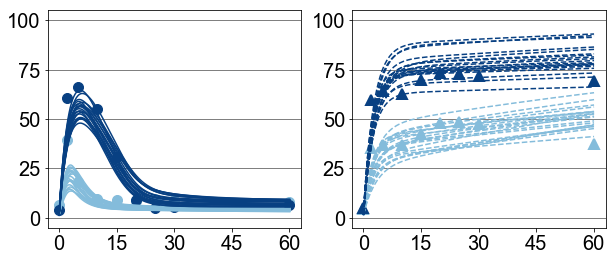

In [55]:
plotting.plt_param_behaviors(M4_fxns, thetas_e4_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [145]:
sims_M4_kb_e4 = plotting.simdata_to_list(M4_fxns, thetas_e4_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


In [ ]:
plotting.plt_ramp_cis(sims_M4_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

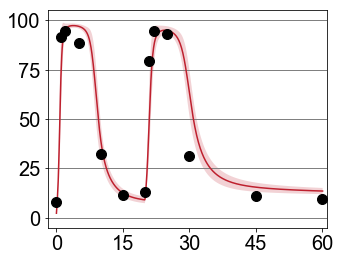

In [147]:

plotting.plt_ramp_cis(sims_M4_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='test.png')
mean =np.mean(np.array(sims_M4_kb_e4), axis=0)
std = np.std(np.array(sims_M4_kb_e4), axis=0)
# print(len(test))
# std = [2*x for i,x in enumerate(std) if i%10==0]
# plt.errorbar([x for i,x in enumerate(time) if i%10==0], [x for i,x in enumerate(mean) if i%10==0], yerr=std, fmt='-o')

## Plotting error on simulations

Tim said to compare bootstrapping the final distribution of thetas and just plotting all of the resulting simulations of that final distribution of thetas. Here I've just done the latter for just WT Hog1 at 550!

In [124]:
colnames = ['idx', 'time', 'value']
sims = pd.DataFrame(columns = colnames)
for idx, params in enumerate(thetas_e3_sort):
        ss_data = model.run_ss(M2b_fxns.m, initials, params_constants, params)
        data = model.simulate_wt_experiment(M2b_fxns.m, ss_data, params_constants, 550000, params, time)
        active = data[:,2]/params_constants[2]*100
        for t, point in enumerate(active):
            sims = sims.append({'idx': idx, 'time': t/10, 'value': point}, ignore_index=True)

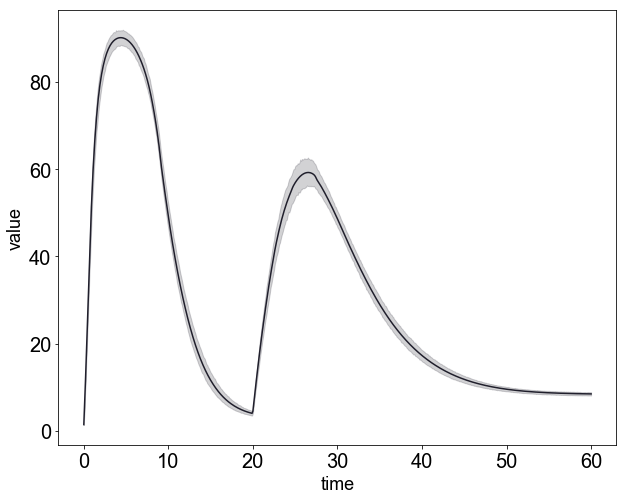

In [132]:
plotting.plt_ramp_cis(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

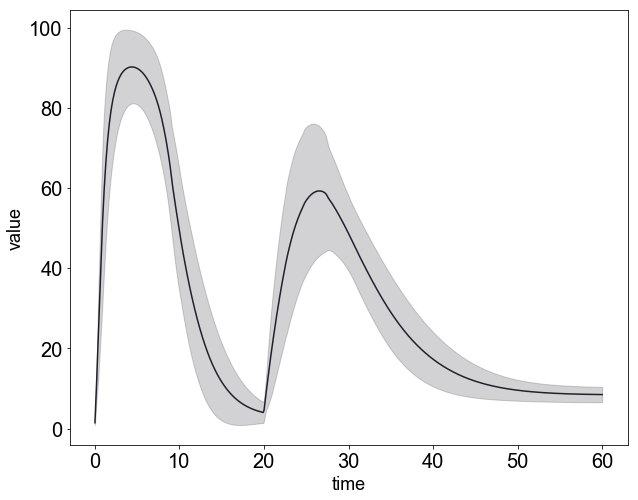

In [133]:
plotting.plt_ramp_cis(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci = 'sd')